In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
## CONFIG
classid = 343

In [3]:
!git clone https://github.com/ml-repro-team-2/re-rosetta.git

Cloning into 're-rosetta'...
remote: Enumerating objects: 186, done.
remote: Counting objects: 100% (186/186), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 186 (delta 35), reused 174 (delta 23), pack-reused 0
Receiving objects: 100% (186/186), 36.12 MiB | 34.86 MiB/s, done.
Resolving deltas: 100% (35/35), done.


In [4]:
cd /kaggle/working/re-rosetta/

/kaggle/working/re-rosetta


In [5]:
# !cp /kaggle/input/class-949/re-rosetta/matches /kaggle/working/re-rosetta -r

In [6]:
#@title Requirements
!pip install -r requirements.txt
!pip install transformers
!pip install openai-clip
!pip install einops
!pip install pytorch_pretrained_biggan
!pip install Ninja
!pip install timm==0.4.12
!pip install dill

  Cloning https://github.com/openai/CLIP.git (to revision b46f5ac7587d2e1862f8b7b1573179d80dcdd620) to /tmp/pip-install-uqevqthd/clip_aeff20b280104bb7b1b163a9e8049b20
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-uqevqthd/clip_aeff20b280104bb7b1b163a9e8049b20
  Running command git rev-parse -q --verify 'sha^b46f5ac7587d2e1862f8b7b1573179d80dcdd620'
  Running command git fetch -q https://github.com/openai/CLIP.git b46f5ac7587d2e1862f8b7b1573179d80dcdd620
  Running command git checkout -q b46f5ac7587d2e1862f8b7b1573179d80dcdd620
  Resolved https://github.com/openai/CLIP.git to commit b46f5ac7587d2e1862f8b7b1573179d80dcdd620
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/arogozhnikov/einops.git (to revision d6f7910dc80c8413b7bb400f6f6ad24e3c5f5b0f) to /tmp/pip-install-uqevqthd/einops_dedd076884fc43a09d2fec34c52de8c4
  Running command git clone --filter=blob:none --quiet https://github.com/arogozhnikov/eino

In [7]:
!pip install gdown

  Obtaining dependency information for gdown from https://files.pythonhosted.org/packages/68/fb/c1bb2cfbf1ad068129e3d67f3420649d38183cca7118f4fa46cfe3c3adab/gdown-5.0.0-py3-none-any.whl.metadata


In [8]:
!gdown "https://drive.google.com/uc?export=download&id=1EX4J4Al5cGC8Z4ZPV5v576LBjLqw_Jt6" -O 'mae_pretrain_vit_base.pth'

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1EX4J4Al5cGC8Z4ZPV5v576LBjLqw_Jt6
From (redirected): https://drive.google.com/uc?export=download&id=1EX4J4Al5cGC8Z4ZPV5v576LBjLqw_Jt6&confirm=t&uuid=d0e559a5-8f17-4553-abde-329f65368274
To: /kaggle/working/re-rosetta/mae_pretrain_vit_base.pth
100%|████████████████████████████████████████| 343M/343M [00:04<00:00, 76.7MB/s]


In [10]:
# ganmode = 'biggan'
# # idx = 207#golden retriever
# for discrmode in ['resnet50','clip','dino','mae','dino_vitb8','dino_vitb16']:

#     save = f"matches/{ganmode}/{discrmode}/19"
#     !python match.py --device "cuda:0" --save_path {save}  --gan_mode {ganmode} --discr_mode {discrmode} --batch_size 2 --epochs 800 --classidx 19
# # discrmode = 'resnet50

In [11]:
from transformers import CLIPProcessor, CLIPModel
import torch
import torchvision
from torchvision.models import resnet50
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import clip
import PIL
from PIL import Image
import requests
import torch.hub
import time
import pickle
import os
import math
import match_utils
from match_utils import matching, stats, proggan, nethook, dataset, models, layers, loading, visualize_pairwisematch
device = torch.device('cuda')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [34]:
from torchvision import datasets
val_dataset = datasets.ImageFolder(root = '/kaggle/input/imagenetmini-1000/imagenet-mini/train')
fname = val_dataset.classes[classid]
ip = f"/kaggle/input/imagenetmini-1000/imagenet-mini/train/{fname}"

In [40]:
!mkdir -p imgs/dir0
!mkdir -p imgs/dir1

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


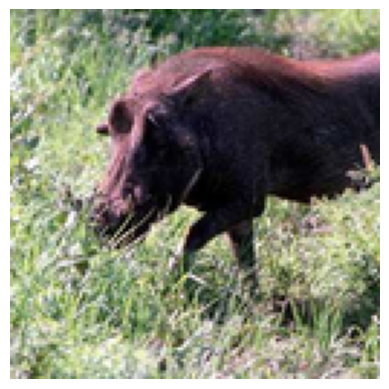

In [44]:
num_steps = 500
lr_rampdown_length = 0.25
lr_rampup_length = 0.05
initial_learning_rate = 0.01
seed = 35
torch.manual_seed(seed)
device = torch.device(device)
discr_mode = "dino"
gan_mode = "styleganxl"

# Load models and tables
discr, discr_layers = models.load_discr(discr_mode, device)

G, gan_layers = models.load_gan(gan_mode, device)
ganlayers, discrlayers = layers.get_layers(
    G, gan_layers, discr, discr_layers, gan_mode, discr_mode, device
)
G = nethook.InstrumentedModel(G)
G.retain_layers(gan_layers, detach=False)
discr = nethook.InstrumentedModel(discr)
discr.retain_layers(discr_layers)

all_images = {}
files = os.listdir(ip)
for file in files:
#     file = file
#     biggan_resolution = 128
    target_fname = f"{ip}/{file}"
    target_pil = PIL.Image.open(target_fname).convert("RGB")
    w, h = target_pil.size
    s = min(w, h)
    target_pil = target_pil.crop(
        ((w - s) // 2, (h - s) // 2, (w + s) // 2, (h + s) // 2)
    )
    target_pil = target_pil.resize(
        (128, 128 ),PIL.Image.LANCZOS
    )
    target_uint8 = np.array(target_pil, dtype=np.uint8)
    plt.axis('off')
    plt.imshow(target_uint8)
    plt.savefig((f"imgs/dir0/{file}").lower(), bbox_inches='tight', pad_inches=0)
#     plt.show()

In [45]:

from scipy.stats import truncnorm


def truncate_noise(size, truncation):
    """
    Function for creating truncated noise vectors: Given the dimensions (n_samples, z_dim)
    and truncation value, creates a tensor of that shape filled with random
    numbers from the truncated normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        truncation: the truncation value, a non-negative scalar
    """

    truncated_noise = truncnorm.rvs(-1 * truncation, truncation, size=size)

    return torch.Tensor(truncated_noise)



In [46]:

# target=torch.tensor(target_uint8.transpose([2, 0, 1]), device=device)


# for i in range(1, 10):
with open(f"imgs/dist.txt", "w") as f:
    f.write("something")


In [22]:
# k = 5
resnet_path = f"/kaggle/input/stylegan-xl128-343/rosetta_neurons/matches/styleganxl/{discr_mode}/{classid}"

table, gan_stats, discr_stats = loading.load_stats(resnet_path, device)
classs = classid

Loading...
Done


In [26]:
code = '''
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import torch
# from torch.autograd import Variable

from lpips.trainer import *
from lpips.lpips import *

def normalize_tensor(in_feat,eps=1e-10):
    norm_factor = torch.sqrt(torch.sum(in_feat**2,dim=1,keepdim=True))
    return in_feat/(norm_factor+eps)

def l2(p0, p1, range=255.):
    return .5*np.mean((p0 / range - p1 / range)**2)

def psnr(p0, p1, peak=255.):
    return 10*np.log10(peak**2/np.mean((1.*p0-1.*p1)**2))

def dssim(p0, p1, range=255.):
    from skimage.measure import compare_ssim
    return (1 - compare_ssim(p0, p1, data_range=range, multichannel=True)) / 2.

def tensor2np(tensor_obj):
    # change dimension of a tensor object into a numpy array
    return tensor_obj[0].cpu().float().numpy().transpose((1,2,0))

def np2tensor(np_obj):
     # change dimenion of np array into tensor array
    return torch.Tensor(np_obj[:, :, :, np.newaxis].transpose((3, 2, 0, 1)))

def tensor2tensorlab(image_tensor,to_norm=True,mc_only=False):
    # image tensor to lab tensor
    from skimage import color

    img = tensor2im(image_tensor)
    img_lab = color.rgb2lab(img)
    if(mc_only):
        img_lab[:,:,0] = img_lab[:,:,0]-50
    if(to_norm and not mc_only):
        img_lab[:,:,0] = img_lab[:,:,0]-50
        img_lab = img_lab/100.

    return np2tensor(img_lab)

def tensorlab2tensor(lab_tensor,return_inbnd=False):
    from skimage import color
    import warnings
    warnings.filterwarnings("ignore")

    lab = tensor2np(lab_tensor)*100.
    lab[:,:,0] = lab[:,:,0]+50

    rgb_back = 255.*np.clip(color.lab2rgb(lab.astype('float')),0,1)
    if(return_inbnd):
        # convert back to lab, see if we match
        lab_back = color.rgb2lab(rgb_back.astype('uint8'))
        mask = 1.*np.isclose(lab_back,lab,atol=2.)
        mask = np2tensor(np.prod(mask,axis=2)[:,:,np.newaxis])
        return (im2tensor(rgb_back),mask)
    else:
        return im2tensor(rgb_back)

def load_image(path):
    if(path[-3:] == 'dng'):
        import rawpy
        with rawpy.imread(path) as raw:
            img = raw.postprocess()
    elif(path[-3:]=='bmp' or path[-3:]=='jpg' or path[-3:]=='png' or path[-4:]=='jpeg'):
        import cv2
        return cv2.imread(path)[:,:,::-1]
    else:
        import matplotlib.pyplot as plt        
        img = (255*plt.imread(path)[:,:,:3]).astype('uint8')

    return img

def tensor2im(image_tensor, imtype=np.uint8, cent=1., factor=255./2.):
    image_numpy = image_tensor[0].cpu().float().numpy()
    image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + cent) * factor
    return image_numpy.astype(imtype)

def im2tensor(image, imtype=np.uint8, cent=1., factor=255./2.):
    return torch.Tensor((image / factor - cent)
                        [:, :, :, np.newaxis].transpose((3, 2, 0, 1)))

def tensor2vec(vector_tensor):
    return vector_tensor.data.cpu().numpy()[:, :, 0, 0]


def voc_ap(rec, prec, use_07_metric=False):
    """ ap = voc_ap(rec, prec, [use_07_metric])
    Compute VOC AP given precision and recall.
    If use_07_metric is true, uses the
    VOC 07 11 point method (default:False).
    """
    if use_07_metric:
        # 11 point metric
        ap = 0.
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap = ap + p / 11.
    else:
        # correct AP calculation
        # first append sentinel values at the end
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))

        # compute the precision envelope
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

        # to calculate area under PR curve, look for points
        # where X axis (recall) changes value
        i = np.where(mrec[1:] != mrec[:-1])[0]

        # and sum (\Delta recall) * prec
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap'''

In [23]:
!pip install lpips

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.5 MB/s eta 0:00:00


In [24]:
!ls /opt/conda/lib/python3.10/site-packages/lpips

__init__.py  __pycache__  lpips.py  pretrained_networks.py  trainer.py	weights


In [27]:
with open("/opt/conda/lib/python3.10/site-packages/lpips/__init__.py","w") as f:
    f.write(code)

In [28]:
import lpips

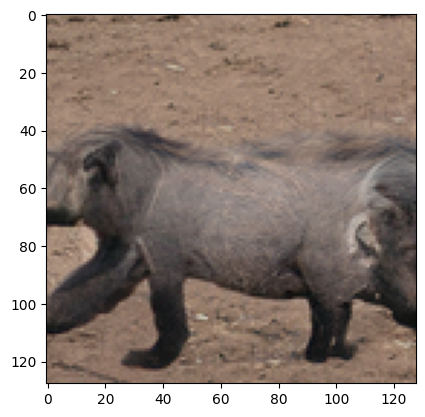

[ step    1/500] [ a_loss: -0.19 loss_reg:  0.06] 


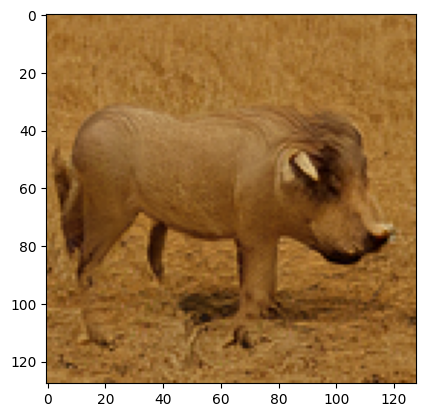

[ step    2/500] [ a_loss: -0.19 loss_reg:  0.06] 
[ step    3/500] [ a_loss: -0.19 loss_reg:  0.06] 
[ step    4/500] [ a_loss: -0.19 loss_reg:  0.06] 
[ step    5/500] [ a_loss: -0.19 loss_reg:  0.06] 
[ step    6/500] [ a_loss: -0.19 loss_reg:  0.06] 
[ step    7/500] [ a_loss: -0.20 loss_reg:  0.06] 
[ step    8/500] [ a_loss: -0.20 loss_reg:  0.06] 
[ step    9/500] [ a_loss: -0.20 loss_reg:  0.06] 
[ step   10/500] [ a_loss: -0.20 loss_reg:  0.06] 
[ step   11/500] [ a_loss: -0.21 loss_reg:  0.06] 
[ step   12/500] [ a_loss: -0.21 loss_reg:  0.06] 
[ step   13/500] [ a_loss: -0.21 loss_reg:  0.06] 
[ step   14/500] [ a_loss: -0.22 loss_reg:  0.06] 
[ step   15/500] [ a_loss: -0.22 loss_reg:  0.06] 
[ step   16/500] [ a_loss: -0.22 loss_reg:  0.06] 
[ step   17/500] [ a_loss: -0.22 loss_reg:  0.06] 
[ step   18/500] [ a_loss: -0.23 loss_reg:  0.06] 
[ step   19/500] [ a_loss: -0.23 loss_reg:  0.06] 
[ step   20/500] [ a_loss: -0.23 loss_reg:  0.06] 
[ step   21/500] [ a_loss: -0.2

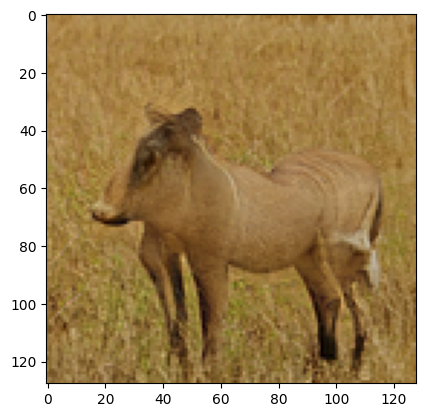

[ step   52/500] [ a_loss: -0.30 loss_reg:  0.06] 
[ step   53/500] [ a_loss: -0.30 loss_reg:  0.06] 
[ step   54/500] [ a_loss: -0.30 loss_reg:  0.06] 
[ step   55/500] [ a_loss: -0.30 loss_reg:  0.06] 
[ step   56/500] [ a_loss: -0.30 loss_reg:  0.06] 
[ step   57/500] [ a_loss: -0.30 loss_reg:  0.06] 
[ step   58/500] [ a_loss: -0.31 loss_reg:  0.06] 
[ step   59/500] [ a_loss: -0.31 loss_reg:  0.06] 
[ step   60/500] [ a_loss: -0.31 loss_reg:  0.06] 
[ step   61/500] [ a_loss: -0.31 loss_reg:  0.06] 
[ step   62/500] [ a_loss: -0.31 loss_reg:  0.06] 
[ step   63/500] [ a_loss: -0.31 loss_reg:  0.06] 
[ step   64/500] [ a_loss: -0.31 loss_reg:  0.06] 
[ step   65/500] [ a_loss: -0.31 loss_reg:  0.06] 
[ step   66/500] [ a_loss: -0.31 loss_reg:  0.06] 
[ step   67/500] [ a_loss: -0.31 loss_reg:  0.06] 
[ step   68/500] [ a_loss: -0.31 loss_reg:  0.06] 
[ step   69/500] [ a_loss: -0.31 loss_reg:  0.06] 
[ step   70/500] [ a_loss: -0.31 loss_reg:  0.06] 
[ step   71/500] [ a_loss: -0.3

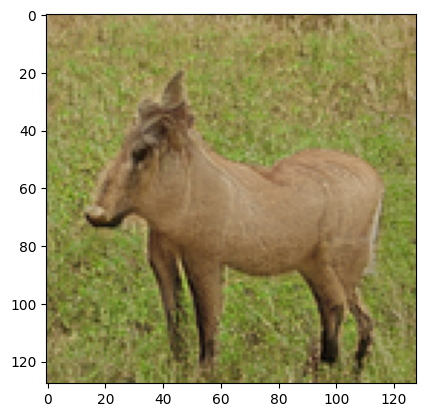

[ step  102/500] [ a_loss: -0.34 loss_reg:  0.06] 
[ step  103/500] [ a_loss: -0.34 loss_reg:  0.06] 
[ step  104/500] [ a_loss: -0.34 loss_reg:  0.06] 
[ step  105/500] [ a_loss: -0.34 loss_reg:  0.06] 
[ step  106/500] [ a_loss: -0.34 loss_reg:  0.06] 
[ step  107/500] [ a_loss: -0.34 loss_reg:  0.06] 
[ step  108/500] [ a_loss: -0.34 loss_reg:  0.06] 
[ step  109/500] [ a_loss: -0.35 loss_reg:  0.06] 
[ step  110/500] [ a_loss: -0.35 loss_reg:  0.06] 
[ step  111/500] [ a_loss: -0.35 loss_reg:  0.06] 
[ step  112/500] [ a_loss: -0.35 loss_reg:  0.06] 
[ step  113/500] [ a_loss: -0.35 loss_reg:  0.06] 
[ step  114/500] [ a_loss: -0.35 loss_reg:  0.06] 
[ step  115/500] [ a_loss: -0.35 loss_reg:  0.06] 
[ step  116/500] [ a_loss: -0.35 loss_reg:  0.06] 
[ step  117/500] [ a_loss: -0.35 loss_reg:  0.06] 
[ step  118/500] [ a_loss: -0.35 loss_reg:  0.06] 
[ step  119/500] [ a_loss: -0.35 loss_reg:  0.06] 
[ step  120/500] [ a_loss: -0.35 loss_reg:  0.06] 
[ step  121/500] [ a_loss: -0.3

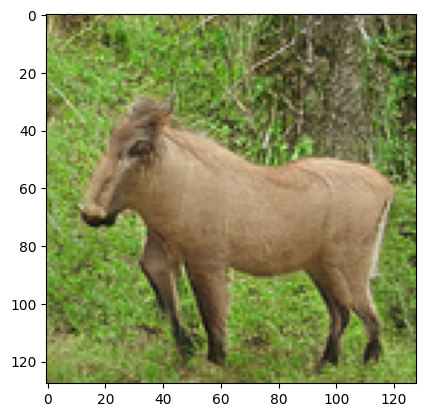

[ step  152/500] [ a_loss: -0.38 loss_reg:  0.06] 
[ step  153/500] [ a_loss: -0.38 loss_reg:  0.06] 
[ step  154/500] [ a_loss: -0.39 loss_reg:  0.06] 
[ step  155/500] [ a_loss: -0.39 loss_reg:  0.06] 
[ step  156/500] [ a_loss: -0.39 loss_reg:  0.06] 
[ step  157/500] [ a_loss: -0.39 loss_reg:  0.06] 
[ step  158/500] [ a_loss: -0.39 loss_reg:  0.06] 
[ step  159/500] [ a_loss: -0.39 loss_reg:  0.06] 
[ step  160/500] [ a_loss: -0.39 loss_reg:  0.06] 
[ step  161/500] [ a_loss: -0.39 loss_reg:  0.06] 
[ step  162/500] [ a_loss: -0.39 loss_reg:  0.06] 
[ step  163/500] [ a_loss: -0.39 loss_reg:  0.06] 
[ step  164/500] [ a_loss: -0.39 loss_reg:  0.06] 
[ step  165/500] [ a_loss: -0.39 loss_reg:  0.06] 
[ step  166/500] [ a_loss: -0.39 loss_reg:  0.06] 
[ step  167/500] [ a_loss: -0.39 loss_reg:  0.06] 
[ step  168/500] [ a_loss: -0.39 loss_reg:  0.06] 
[ step  169/500] [ a_loss: -0.39 loss_reg:  0.06] 
[ step  170/500] [ a_loss: -0.39 loss_reg:  0.06] 
[ step  171/500] [ a_loss: -0.3

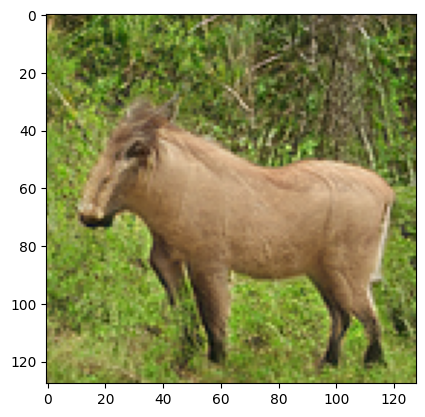

[ step  202/500] [ a_loss: -0.41 loss_reg:  0.06] 
[ step  203/500] [ a_loss: -0.41 loss_reg:  0.06] 
[ step  204/500] [ a_loss: -0.41 loss_reg:  0.06] 
[ step  205/500] [ a_loss: -0.41 loss_reg:  0.06] 
[ step  206/500] [ a_loss: -0.41 loss_reg:  0.06] 
[ step  207/500] [ a_loss: -0.41 loss_reg:  0.06] 
[ step  208/500] [ a_loss: -0.41 loss_reg:  0.06] 
[ step  209/500] [ a_loss: -0.41 loss_reg:  0.06] 
[ step  210/500] [ a_loss: -0.41 loss_reg:  0.06] 
[ step  211/500] [ a_loss: -0.41 loss_reg:  0.06] 
[ step  212/500] [ a_loss: -0.41 loss_reg:  0.06] 
[ step  213/500] [ a_loss: -0.41 loss_reg:  0.06] 
[ step  214/500] [ a_loss: -0.41 loss_reg:  0.06] 
[ step  215/500] [ a_loss: -0.41 loss_reg:  0.06] 
[ step  216/500] [ a_loss: -0.41 loss_reg:  0.06] 
[ step  217/500] [ a_loss: -0.41 loss_reg:  0.06] 
[ step  218/500] [ a_loss: -0.41 loss_reg:  0.06] 
[ step  219/500] [ a_loss: -0.41 loss_reg:  0.06] 
[ step  220/500] [ a_loss: -0.41 loss_reg:  0.06] 
[ step  221/500] [ a_loss: -0.4

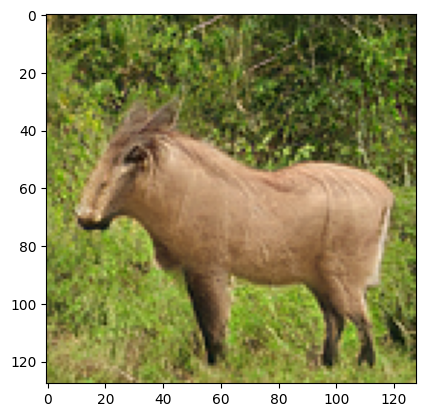

[ step  252/500] [ a_loss: -0.42 loss_reg:  0.06] 
[ step  253/500] [ a_loss: -0.42 loss_reg:  0.06] 
[ step  254/500] [ a_loss: -0.42 loss_reg:  0.06] 
[ step  255/500] [ a_loss: -0.42 loss_reg:  0.06] 
[ step  256/500] [ a_loss: -0.42 loss_reg:  0.06] 
[ step  257/500] [ a_loss: -0.42 loss_reg:  0.06] 
[ step  258/500] [ a_loss: -0.42 loss_reg:  0.06] 
[ step  259/500] [ a_loss: -0.42 loss_reg:  0.06] 
[ step  260/500] [ a_loss: -0.42 loss_reg:  0.06] 
[ step  261/500] [ a_loss: -0.42 loss_reg:  0.06] 
[ step  262/500] [ a_loss: -0.42 loss_reg:  0.06] 
[ step  263/500] [ a_loss: -0.42 loss_reg:  0.06] 
[ step  264/500] [ a_loss: -0.42 loss_reg:  0.06] 
[ step  265/500] [ a_loss: -0.42 loss_reg:  0.06] 
[ step  266/500] [ a_loss: -0.42 loss_reg:  0.06] 
[ step  267/500] [ a_loss: -0.42 loss_reg:  0.06] 
[ step  268/500] [ a_loss: -0.42 loss_reg:  0.06] 
[ step  269/500] [ a_loss: -0.42 loss_reg:  0.06] 
[ step  270/500] [ a_loss: -0.42 loss_reg:  0.06] 
[ step  271/500] [ a_loss: -0.4

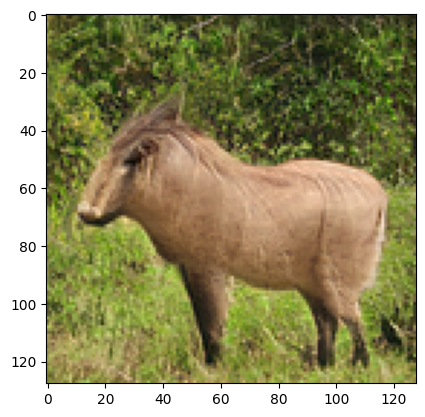

[ step  302/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  303/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  304/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  305/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  306/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  307/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  308/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  309/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  310/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  311/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  312/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  313/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  314/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  315/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  316/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  317/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  318/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  319/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  320/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  321/500] [ a_loss: -0.4

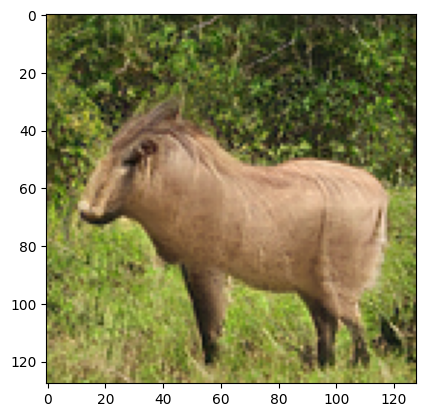

[ step  352/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  353/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  354/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  355/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  356/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  357/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  358/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  359/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  360/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  361/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  362/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  363/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  364/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  365/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  366/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  367/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  368/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  369/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  370/500] [ a_loss: -0.43 loss_reg:  0.06] 
[ step  371/500] [ a_loss: -0.4

In [ ]:

gan_matches = torch.argmax(table, 1)
_, discr_matches = torch.topk(table, k=1, dim=0)

##get best buddies
perfect_matches = []
discr_perfect_matches = []
num_perfect_matches = 0
for i in range(table.shape[0]):
    gan_match = gan_matches[i].item()
    discr_match = discr_matches[:, gan_match]
    if discr_match.ndim == 1:
        if i in discr_match:
            num_perfect_matches += 1
            perfect_matches.append(i)
            discr_perfect_matches.append(gan_match)
    else:
        if i == discr_match:
            num_perfect_matches += 1
            perfect_matches.append(i)
            discr_perfect_matches.append(gan_match)
#     getting everything in (layer, unit) form
for i, unit in enumerate(perfect_matches):
    perfect_matches[i] = layers.find_act(perfect_matches[i], ganlayers)
for i, unit in enumerate(discr_perfect_matches):
    discr_perfect_matches[i] = layers.find_act(
        discr_perfect_matches[i], discrlayers
    )
all_images = {}
image_resolution = 128
files = os.listdir(ip)
for file in files:
    target_fname = f"{ip}/{file}"
    discr_im = Image.open(target_fname).convert("RGB")
    discr_im = torchvision.transforms.ToTensor()(discr_im).unsqueeze(0).to(device)

    discr_im = torch.nn.functional.interpolate(
        discr_im, size=(224, 224), mode="bicubic"
    )
    discr_im = torchvision.transforms.Normalize(
        (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
    )(discr_im)
    #         plt.imshow(discr_im.squeeze().permute(1,2,0).cpu())
    #         plt.show()

    _ = discr(discr_im)
    discr_activs = matching.store_activs(discr, discr_layers)

    # normalize
    eps = 0.00001
    for i, _ in enumerate(discr_activs):
        discr_activs[i] = (discr_activs[i] - discr_stats[i][0]) / (
            discr_stats[i][1] + eps
        )

    discr_perfect_activs = []
    for idx in discr_perfect_matches:
        discr_perfect_activs.append(
            discr_activs[idx[0]][:, idx[1], :, :].unsqueeze(0)
        )

    #     target_images = target.unsqueeze(0).to(device).to(torch.float32)
    z = truncate_noise((1, 64), 1).to(device)
    c = torch.zeros((1, 1000)).to(device)
    c[0, classs] = 1
    im = G(z, c, 1)
    im = im[0].permute((1, 2, 0))
    im = (im + 1) / 2

    plt.imshow(im.detach().cpu())
    plt.show()

    z1 = torch.tensor(
        truncate_noise((1, 64), 1),
        dtype=torch.float32,
        device=device,
        requires_grad=True,
    ).to(
        device
    )  # pylint: disable=not-callable
    optimizer = torch.optim.Adam([z1], betas=(0.9, 0.999), lr=initial_learning_rate)
    # @title Inversion
    # all_images = []
    for step in range(num_steps):
        # Learning rate schedule.
        t = step / num_steps
        lr_ramp = min(1.0, (1.0 - t) / lr_rampdown_length)
        lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
        lr_ramp = lr_ramp * min(1.0, t / lr_rampup_length)
        lr = initial_learning_rate * lr_ramp
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr

        # Synth images from opt_w.
        synth_images = G(z1, c, 1)

        # track images
        synth_images = (synth_images + 1) * (255 / 2)
        synth_images_np = (
            synth_images.clone()
            .detach()
            .permute(0, 2, 3, 1)
            .clamp(0, 255)
            .to(torch.uint8)[0]
            .cpu()
            .numpy()
        )
        #     all_images.append(synth_images_np)

        # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
#             if synth_images.shape[2] > 256:
#                 synth_images = F.interpolate(synth_images, size=(256, 256), mode="area")

        gan_activs = matching.store_activs(G, gan_layers)
        # normalize all activations
        eps = 0.00001
        for i, _ in enumerate(gan_activs):
            gan_activs[i] = (gan_activs[i] - gan_stats[i][0]) / (
                gan_stats[i][1] + eps
            )

        gan_perfect_activs = []
        for idx in perfect_matches:
            gan_perfect_activs.append(gan_activs[idx[0]][:, idx[1], :, :])

        # pearson correlation
        a_loss = 0
        counter = len(gan_perfect_activs)
        for i, _ in enumerate(gan_perfect_activs):
            map_size = max(
                (gan_perfect_activs[i].shape[1], discr_perfect_activs[i].shape[1])
            )
            gan_activ_new = torch.nn.Upsample(
                size=(map_size, map_size), mode="bilinear"
            )(gan_perfect_activs[i].unsqueeze(0))
            discr_activ_new = torch.nn.Upsample(
                size=(map_size, map_size), mode="bilinear"
            )(discr_perfect_activs[i])
            prod = torch.einsum("aixy,ajxy->ij", gan_activ_new, discr_activ_new)
            div1 = torch.sum(gan_activ_new**2)
            div2 = torch.sum(discr_activ_new**2)
            corr = prod / torch.sqrt(div1 * div2)
            a_loss += corr

        a_loss *= -1
        a_loss = a_loss / counter
        l_reg = torch.mean((z1 - z) ** 2)
        # Features for synth images.
        loss = a_loss + 0 * l_reg
        # Step
        optimizer.zero_grad(set_to_none=True)

        loss.backward()
        optimizer.step()
        msg  = f'[ step {step+1:>4d}/{num_steps}] '
        msg += f'[ a_loss: {float(a_loss):5.2f} loss_reg: {0.1 * float(l_reg):5.2f}] '
        print(msg)
        if step == num_steps - 1:
            plt.imshow(synth_images_np)
            plt.axis('off')
            plt.savefig(f"imgs/dir1/{file}".lower(), bbox_inches='tight', pad_inches=0)
        if step % 50 == 0:
            plt.imshow(synth_images_np)
            plt.show()


In [ ]:
 command = f"python calc_metrics.py  --dir0 imgs/dir0 --dir1 imgs/dir1 -o imgs/dist{k}.txt --use_gpu --version 0.1"
                os.system(command)